<a href="https://colab.research.google.com/github/minsaee/github_workspace/blob/master/411_%EC%8A%A4%EC%BC%80%EC%A4%84%EB%A7%81_%EC%A3%BC%EC%8B%9D%EB%B3%B4%EA%B3%A0%EC%84%9C_%EB%A9%94%EC%9D%BC%EB%A1%9C_%EB%B3%B4%EB%82%B4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/ai_chat_python'

Mounted at /content/drive
/content/drive/MyDrive/ai_chat_python


In [2]:
!pip install flask
!pip install apscheduler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 1.9 MB/s eta 0:00:00


In [8]:
from flask import Flask
from apscheduler.schedulers.background import BackgroundScheduler

#daemon=True을 하면 Flask program을 종료할때 스케줄러도 종료해 준다.
schedule = BackgroundScheduler(daemon=True, timezone='Asia/Seoul')

# 스케줄러의 사용 가능한 작업 목록을 5초마다 업데이트한다.
#schedule.add_job(hello,'cron',day_of_week='mon-fri',  hour='9-18',  minute='*/1')

@schedule.scheduled_job('cron', day_of_week='mon-fri', hour='9-23', minute='*/1'   )
def hello():
    print('test')

# 스케줄러 시작
schedule.start()

app = Flask(__name__)

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


test
test


In [ ]:
# 스케줄러 종료
#schedule.shutdown()

In [4]:
!pip install pyngrok
!pip install flask_ngrok
!pip install python-pptx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.7 MB/s eta 0:00:00


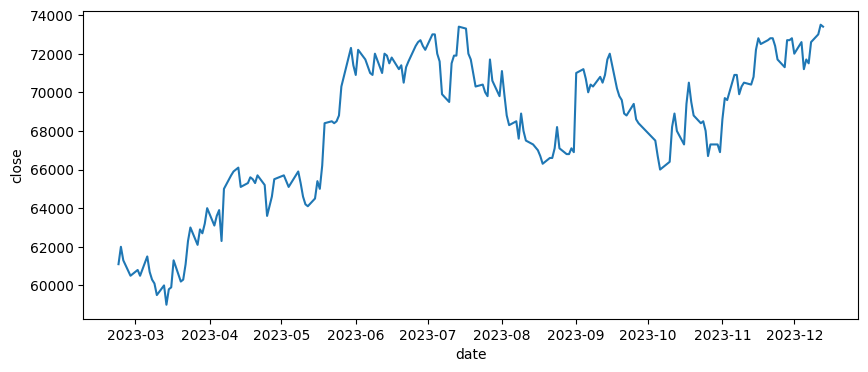

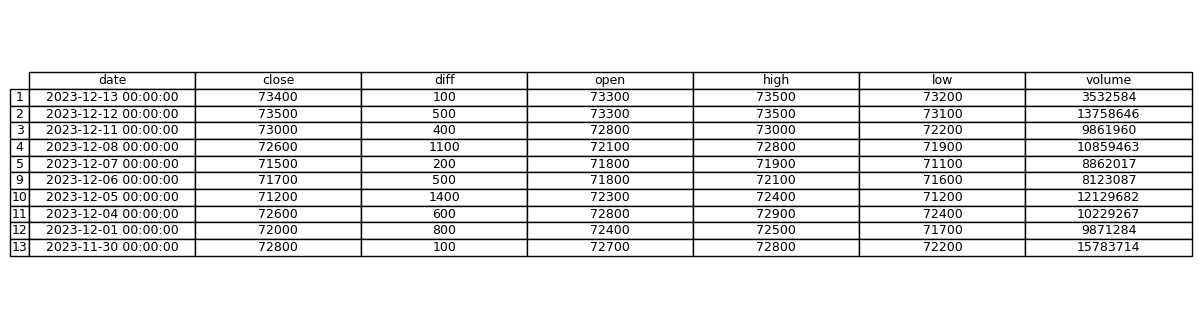

In [9]:
import matplotlib.pyplot as plt
from pandas.plotting import table
import os
import pandas as pd
import requests

import datetime
from pptx  import Presentation
from pptx.util  import Inches
import os

import smtplib

# 이메일 메시지에 다양한 형식을 중첩하여 담기 위한 객체
from email.mime.multipart import MIMEMultipart

# 이메일 메시지를 이진 데이터로 바꿔주는 인코더
from email import encoders

# 텍스트 형식
from email.mime.text import MIMEText
# 이미지 형식
from email.mime.image import MIMEImage
# 오디오 형식
from email.mime.audio import MIMEAudio

# 위의 모든 객체들을 생성할 수 있는 기본 객체
# MIMEBase(_maintype, _subtype)
# MIMEBase(<메인 타입>, <서브 타입>)
from email.mime.base import MIMEBase

###################
##함수 정의##
###################
def get_stock_code():
  # 종목코드 다운로드
  stock_code = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header =0)[0]
  #print(stock_code)

  #필요없는 column들은 제외
  stock_code = stock_code[['회사명','종목코드']]

  #한글컬럼명을 영어로 변경
  stock_code = stock_code.rename(columns={'회사명':'company', '종목코드':'code'})


  #종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해준다.
  stock_code.code = stock_code.code.map('{:06d}'.format)
  return stock_code


def get_stock(code):
  df = pd.DataFrame()
  for page in range(1,21):
  # 일별 시세 url
    url = 'https://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code)
    url = '{url}&page={page}'.format(url=url, page=page)
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'}
    res = requests.get(url, headers=header)
    current_df = pd.read_html(res.text, header=0)[0]
    df = pd.concat([df, current_df], ignore_index=True)
  return df

def clean_data(df):
  #df.dropan()를 이용해 결측값 있는 행 제거
  df = df.dropna()

  #한글로 된 컬럼명을 영어로 바꿔줌
  df = df.rename(columns={'날짜':'date','종가':'close', '전일비':'diff', '시가':'open' ,'고가':'high', '저가':'low', '거래량':'volume'})
  #데이터 타입을 int형으로 바꿔줌
  df[['close','diff','open','high','low','volume']] = df[['close','diff','open','high','low','volume']].astype(int)
  # 컬럼명 'date'의 타입을 date로 바꿔줌
  df['date'] = pd.to_datetime(df['date'])
  print('data : ', df['date'])
  #일자(date)을 기준으로 오름차순 정렬
  df = df.sort_values(by=['date'], ascending=True)
  return df

###############################
## 함수 정의
###############################
def send_email(smtp_info, msg):
  with smtplib.SMTP(smtp_info['smtp_server'], smtp_info['smtp_port']) as server:
    #TLS 보안 연결
    server.starttls()
    #로그인
    server.login(smtp_info['smtp_user_id'], smtp_info['smtp_user_pw'])

    #로그인 된 서버에 이메일 전송
                #메시지를 보낼때는 as_string()메소드를 사용해서 문자열로 바꿔준다.
    response = server.sendmail(msg['From'], msg['To'], msg.as_string())


    #이메일을 성공적으로 보내면 결과는{}
    if not response:
      print('이메일을 성공적으로 보냈습니다.')
    else:
      print(response)

def make_multimsg(msg_dict):
  multi = MIMEMultipart(_subtype='mixed')

  for key, value in msg_dict.items():
    #각 타입에 적절한 MIMExxx()함수를 호출하여 msg객체를 생성한다.
    if key == 'text':
      with open(value['filename'], encoding='utf-8') as fp:
                msg = MIMEText(fp.read(), _subtype=value['subtype'])
    elif key == 'image':
      with open(value['filename'], 'rb') as fp:
                msg = MIMEImage(fp.read(), _subtype=value['subtype'])
    elif key == 'audio':
      with open(value['filename'], 'rb') as fp:
                msg = MIMEAudio(fp.read(), _subtype=value['subtype'])
    else:
      with open(value['filename'], 'rb') as fp:
                msg = MIMEBase(value['maintype'], _subtype=value['subtype'])
                msg.set_payload(fp.read())
                encoders.encode_base64(msg)

    #경로가 있는 경우, 파일의 이름만 추출  ex)res/stock_report/stock_report.pptx  -> stock_report.pptx
    _, fname = os.path.split(value['filename'])
    print(fname)
    #파일 이름을 첨부파일 제목으로 추가
    msg.add_header('Content-Disposition', 'attachment', filename = fname)

    #첨부파일 추가
    multi.attach(msg)
  return multi

def do():

  ###################
  ##함수 호출##
  ###################
  # 종목코드 가져오기
  company = '삼성전자'
  stock_code = get_stock_code()

  #일별 시세 가져오기
  code = stock_code[stock_code.company==company].code.values[0].strip()  ##strip():공백제거
  df = get_stock(code)

  #일별 시세 클린징
  df = clean_data(df)
  ##############
  #차트 그리기
  ###############
  plt.figure(figsize=(10,4))
  plt.plot(df['date'], df['close'])
  plt.xlabel('date')
  plt.ylabel('close')

  ######################
  ##차트 저장 및 출력하기
  ######################
  chart_fname = os.path.join('res/stock_report', '{company}_chart.png'.format(company=company))
  plt.savefig(chart_fname)
  #plt.show()

  #####################
  ##일별 시세 그리기
  #####################
  plt.figure(figsize=(15,4))
  ax = plt.subplot(111, frame_on=False)  #no visible frame
  ax.xaxis.set_visible(False)            # hide the x axis
  ax.yaxis.set_visible(False)            # hide the y axis
  df = df.sort_values(by=['date'], ascending=False)  # 내림차순
  table(ax, df.head(10), loc='center', cellLoc='center', rowLoc='center')

  ####################
  ## 일별 시세 저장하기
  ####################
  table_fname = os.path.join("res/stock_report", '{company}_table.png'.format(company=company))
  plt.savefig(table_fname)



  ###########################
  ## 파워포인트 객체 선언
  ##########################
  today = datetime.datetime.today().strftime('%Y%m%d')
  prs=Presentation()  # 파워포인트 객체 선언

  ###########################
  ## 슬라이드 추가
  ##########################
  title_slide_layout = prs.slide_layouts[0]   #제목 슬라이드 생성
  slide = prs.slides.add_slide(title_slide_layout)

  #제목 - 제목에 값 넣기
  title = slide.shapes.title    #제목
  title.text = '주식 보고서'    #제목에 값 넣기

  #부제목
  subtitle = slide.placeholders[1]  #제목 상자는 placeholders[0], 부제목 상자는[1]
  subtitle.text = '보고서 작성일 : {date}'.format(date=today)

  ############################
  ##차트 및 테이블 슬라이드 추가
  ############################
  title_only_slide_layout = prs.slide_layouts[5]  #제목만 있는 슬라이드
  slide = prs.slides.add_slide(title_only_slide_layout)

  shapes = slide.shapes
  shapes.title.text = '{company}, {close}원에 거래 마감'.format(company=company, close=df.iloc[0]['close'])
  print(shapes.title.text)

  #차트 추가
  top = Inches(2)
  left = Inches(0.5)
  height = Inches(2.5)
  width = Inches(9)
  pic = slide.shapes.add_picture(chart_fname, left=left, top=top, width=width, height=height)

  #테이블 추가
  left = Inches(-1)
  height = Inches(3)
  width = Inches(12)
  top = Inches(4)
  pic = slide.shapes.add_picture(table_fname, left=left, top=top, width=width, height=height)

  cursor_sp = slide.shapes[0]._element
  cursor_sp.addprevious(pic._element)    #해당 요소를 뒤로 보낸다.


  #####################
  ##보고서 저장
  ####################
  ppt_fname = os.path.join('res/stock_report', 'stock_report.pptx')
  prs.save(ppt_fname)




  ###############################
  ## 함수 호출
  ###############################
  # smtp_info = dict({"smtp_server" : "smtp.naver.com", # SMTP 서버 주소
  #                   "smtp_user_id" : "<송신자(sender) 메일 계정>@naver.com",
  #                   "smtp_user_pw" : "<송신자(sender) 메일 패스워드>",
  #                   "smtp_port" : 587}) # SMTP 서버 포트

  smtp_info = dict({"smtp_server" : "smtp.naver.com", # SMTP 서버 주소
                    "smtp_user_id" : "@naver.com",
                    "smtp_user_pw" : "pw",
                    "smtp_port" : 587}) # SMTP 서버 포트

  msg_dict = {
      'application' : {'maintype' : 'application', 'subtype' : 'octect-stream', 'filename' : 'res/email_sending/test.pdf'} # 그외 첨부파일
  }

  #메일 내용 작성
  title = '({date}). 주식 보고서 분석 자료 입니다.'.format(date=today)
  content = '주식 보고서 분석 자료 입니다.'
  sender = smtp_info['smtp_user_id']
  receiver = '@daum.net'

  msg = MIMEText(_text = content, _charset='utf-8')

  #첨부파일 추가
  msg_dict['application']['filename'] = ppt_fname
  multi = make_multimsg(msg_dict)
  multi['Subject'] = title
  multi['From'] = sender
  multi['To'] = receiver
  multi.attach(msg)

  send_email(smtp_info, multi)

In [10]:
#import threading


from flask import Flask,render_template
from pyngrok import ngrok
from flask import Flask
from apscheduler.schedulers.background import BackgroundScheduler

#daemon=True을 하면 Flask program을 종료할때 스케줄러도 종료해 준다.
schedule = BackgroundScheduler(daemon=True, timezone='Asia/Seoul')

app = Flask(__name__)

port=5000
ngrok.set_auth_token('token')
public_url = ngrok.connect(port).public_url
print('click', public_url)
app.config['BASE_URL']=public_url

@app.route("/")
def hello_world():
  return '<h1>test</h1>'

@schedule.scheduled_job('cron', day_of_week='mon-fri', hour='9-23', minute='*/1' )
def hello_world():
    do()



# 스케줄러 시작
schedule.start()


if __name__ == '__main__':
    #app.debug = True
    app.run()

click https://22a4-34-168-89-224.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
